# Pycaret Model

### First, import the necessary libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pycaret.regression import setup, compare_models, finalize_model, predict_model


### Load the datasets

In [3]:
# Load training and testing datasets
print('Loading training and testing datasets...')
train_data = pd.read_csv('datasets/train_data.csv')
test_data = pd.read_csv('datasets/test_data.csv')
print('Datasets loaded successfully.')


Loading training and testing datasets...
Datasets loaded successfully.


### Extract features, drop unnecessary columns, and deal with the outliers from years to improve the model's precision

In [4]:
# Step 3: Feature Engineering: Extract more features from the date
train_data['year'] = pd.to_datetime(train_data['date_of_transfer']).dt.year
train_data['month'] = pd.to_datetime(train_data['date_of_transfer']).dt.month
test_data['year'] = pd.to_datetime(test_data['date_of_transfer']).dt.year
test_data['month'] = pd.to_datetime(test_data['date_of_transfer']).dt.month

# Drop irrelevant columns
train_data = train_data.drop(columns=['transaction_unique_identifier', 'record_status_-_monthly_file_only'], errors='ignore')
test_data = test_data.drop(columns=['transaction_unique_identifier', 'record_status_-_monthly_file_only'], errors='ignore')

# Handling outliers using Z-score
numeric_cols = train_data.select_dtypes(include=['float64', 'int64']).columns
for col in numeric_cols:
    z_scores = np.abs((train_data[col] - train_data[col].mean()) / train_data[col].std())
    train_data = train_data[z_scores < 3]




### The dataset is too big to create a model of it, it would take ages so I decided to reduce the size of the dataset with the sample() function. Funny thing I managed to find out, the more samples we have got, the higher the r2 score is.

### Next we split the data into features (x) and target (y) to separate the dataset into features (input) and target (output)

### After that, we are using the test dataset for testing and combinig the features and targets for the PyCaret setup.

In [5]:

# Reduce dataset size for faster modeling
train_data_sampled = train_data.sample(100000, random_state=42)

# Split data into features (X) and target (y)
X_train = train_data_sampled.drop(columns=['price'])
y_train = train_data_sampled['price']

# Use the test dataset as is for testing
X_test = test_data.drop(columns=['price'])
y_test = test_data['price']

# Combine features and target for PyCaret setup
train_data_for_pycaret = pd.concat([X_train, y_train], axis=1)


### Once we got this done, lets proceed to initializing PyCaret, setup the environment and compare models to look for the best one.

In [6]:

# Initialize PyCaret for regression with training data
print("Initializing PyCaret for regression...")
reg_experiment = setup(data=train_data_for_pycaret,
                       target='price',
                       session_id=42,
                       verbose=False)
print("Setup completed. Proceeding with model comparison...")

print("Comparing models excluding LightGBM...")
best_model = compare_models(exclude=['lightgbm', 'lgbm', 'lgb', 'gbr', 'xgboost', 'catboost'])
print("Best model selected.")


Initializing PyCaret for regression...
Setup completed. Proceeding with model comparison...
Comparing models excluding LightGBM...


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,62606.7321,8560625474.2270,92514.9477,0.5367,0.3803,0.3281,5.4180
lr,Linear Regression,65732.8647,8932645061.8181,94507.9386,0.5166,0.4227,0.3474,1.0840
lasso,Lasso Regression,65732.8365,8932669298.6234,94508.0676,0.5166,0.4227,0.3474,1.7270
ridge,Ridge Regression,65732.9251,8932659923.0988,94508.0177,0.5166,0.4227,0.3474,0.2120
lar,Least Angle Regression,65732.8647,8932645061.8176,94507.9386,0.5166,0.4227,0.3474,0.2210
llar,Lasso Least Angle Regression,65732.8574,8932669363.7223,94508.0680,0.5166,0.4227,0.3474,0.2250
et,Extra Trees Regressor,64453.6643,9203126547.5142,95923.7984,0.5020,0.3921,0.3351,4.4880
en,Elastic Net,71758.7510,10428191009.6690,102113.7831,0.4357,0.4364,0.3987,0.4190
ada,AdaBoost Regressor,82613.8756,11277645104.1327,106155.1502,0.3896,0.4873,0.5193,1.0560
br,Bayesian Ridge,79615.4726,12305871417.3326,110927.6755,0.3340,0.4825,0.4533,0.2290


Best model selected.


### In my case the GradientBooster won, but because I am currently using it in a different model I chose to exclude this one and use the model that performed the best except for GradientBooster

### The next step is to finalize the model that will be used in our predictions

In [7]:

# Finalize the best model
print("Finalizing the best model...")
final_model = finalize_model(best_model)


Finalizing the best model...


### Now, we can start making predictions for the years 2016-17 based on the model trained on the data from the years 2009-2015. After that, I extractet the year and month from date_of_transaction by converting it into datetime format. Then I ensured the DataFrame for predicions matches the test data length and at the end added the columns Year, Month and Actual Price to our prediction dataframe

In [8]:

# Make predictions on the test data (which includes years 2016 and 2017)
print("Making predictions on the test data...")
predictions = predict_model(final_model, data=X_test)

# Ensure predictions DataFrame matches test data length
predictions = predictions.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

# Add year and month columns to both the test and prediction dataframes
print("Adding year and month columns...")
test_data['year'] = pd.to_datetime(test_data['date_of_transfer']).dt.year
test_data['month'] = pd.to_datetime(test_data['date_of_transfer']).dt.month

# Ensure the length matches
if len(predictions) != len(test_data):
    min_length = min(len(predictions), len(test_data))
    predictions = predictions[:min_length]
    test_data = test_data[:min_length]

# Add year, month, and actual price columns to predictions DataFrame
label_column = 'Label' if 'Label' in predictions.columns else 'prediction_label'
predictions['year'] = test_data['year']
predictions['month'] = test_data['month']
predictions['price'] = y_test.values


Making predictions on the test data...


Adding year and month columns...


### In the second last step we have to save the predictions to compare them with the actual data from the test.csv

In [9]:

# Save predictions for comparison
predictions_path = 'datasets/predictions_pycaret.csv'
predictions.to_csv(predictions_path, index=False)
print(f"Predictions saved to {predictions_path}")


Predictions saved to datasets/predictions_pycaret.csv


### And finally, I created a comparision between the prediction and the actual UK Housing prices and ended up with this beautiful graph.

Aggregating data for better visualization...


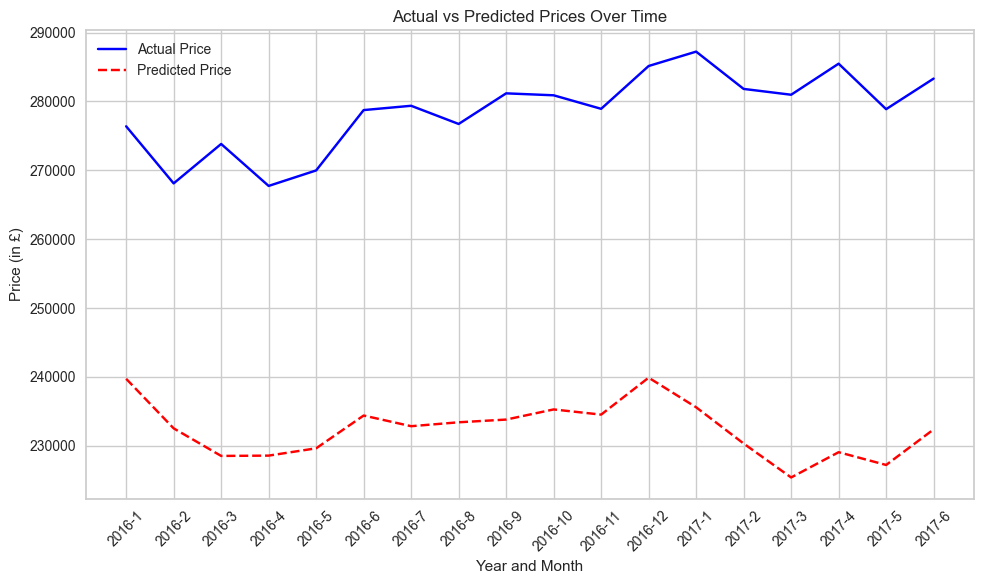

In [10]:

# Aggregating Data for Better Visualization
print("Aggregating data for better visualization...")
aggregated_data = predictions.groupby(['year', 'month']).agg({'price': 'mean', label_column: 'mean'}).reset_index()
aggregated_data['year_month'] = aggregated_data['year'].astype(str) + '-' + aggregated_data['month'].astype(str)

# Plot actual vs predicted values over time
plt.figure(figsize=(10, 6))
plt.plot(aggregated_data['year_month'], aggregated_data['price'], label='Actual Price', color='blue')
plt.plot(aggregated_data['year_month'], aggregated_data[label_column], label='Predicted Price', color='red', linestyle='--')
plt.xlabel('Year and Month')
plt.ylabel('Price (in £)')
plt.xticks(rotation=45)
plt.title('Actual vs Predicted Prices Over Time')
plt.legend()
plt.tight_layout()
plt.show()
